# Validate PFOA PBK model implementation in Antimony

In [1]:
import re
import math
import pandas as pd
import tellurium as te
import libsbml as ls
import pandas as pd
import matplotlib.pyplot as plt

fn_ant = '../Model/Antimony/PBK_PFAS.ant'


In [2]:
r = te.loada(fn_ant)

In [29]:
# Helper function for plotting simulation results
def plotSimulationResults(res, selections):
    fig, axes = plt.subplots(3,math.ceil((len(selections) - 1)/3),figsize=(10,6))
    axes = axes.flatten()
    for ax in axes:
        ax.set(xlabel='time') 
    labels = selections
    for i in range(1, len(selections)):
        sid = selections[i]
        axes[i-1].plot(res['time'], res[sid])
        axes[i-1].set(ylabel=f"Amount", title=labels[i])
    fig.tight_layout()

# Helper function for generating dosing events
def generateDoseEventsPattern(amount, start, step, stop):
    timings = range(start, stop, step)
    events = []
    for timing in timings:
        events.append((timing, amount))
    return events

def loadParametrisation(model, filename):
    df = pd.read_csv(filename)
    df['Value'] = df['Value'].astype(float)
    for index, row in df.iterrows():
        model[str(row['Parameter'])] = row['Value']


## Run multiple doses

In [33]:
# Load the PBPK model from the SBML file
rr_model = te.loada(fn_ant)

# Specify the input
input_id = 'AG'

# Make sure A_gut is not constant and does not have boundary conditions
rr_model.setInitAmount(input_id, 0)
rr_model.setConstant(input_id, False)
rr_model.setBoundary(input_id, False)

# Remove all events
for event_id in rr_model.model.getEventIds():
    rr_model.removeEvent(event_id)

bw = 70
daily_intake = 3.55 * 0.011 * bw # ug/d (0.00355 mg/l * 11 mL/kg/day)
days_of_exposure = 30 * 365
days_after_exposure = 10 * 365
num_days = days_of_exposure + days_after_exposure

print(daily_intake)

# Define a list of time/dose tuples
time_dose_list = generateDoseEventsPattern(daily_intake, 1, 1, days_of_exposure)

# Set chemical parameters
loadParametrisation(rr_model, '../Parametrisations/PFOA_Human.csv')
rr_model.QLC = 0.25

# Set physiological parameters
rr_model.BW = bw

# Create an event for each of the time-dose tuples
for i in range(0, len(time_dose_list)):
    dose_event = time_dose_list[i]
    eid = f"oral_dose_event_{i}"
    rr_model.addEvent(eid, False, f"time > {dose_event[0]}", False)
    rr_model.addEventAssignment(eid, input_id, f"{input_id} + {dose_event[1]}", False)
rr_model.regenerateModel(True, True)

# Simulate the PBPK model
results = rr_model.simulate(start=0, end=num_days, points=num_days * 4)


2.7335


## Report results

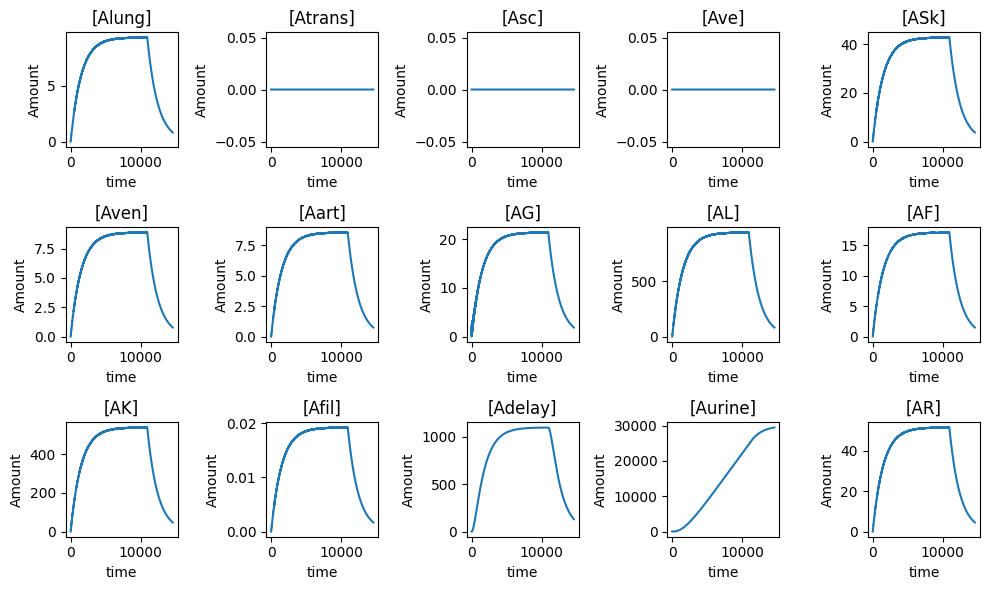

In [34]:
# Plot the results
plotSimulationResults(results, rr_model.timeCourseSelections)


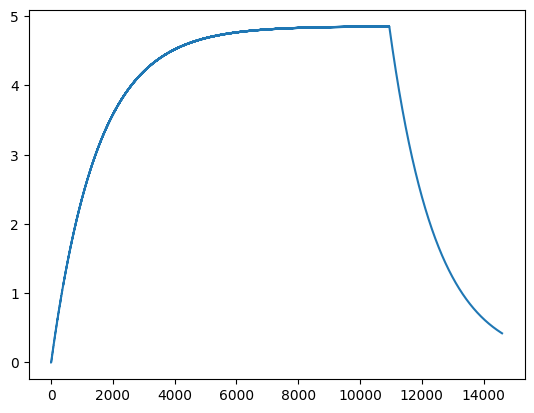

In [35]:
compartment = "Ven"
speciesId = "[Aven]"

x = results['time']
y = results[speciesId] / rr_model[compartment]
plt.plot(x, y)
plt.title = compartment
plt.xlabel = 'Time (d)'
plt.ylabel = 'Concentration (ug/L)'